In [0]:
# TO-DO
# AUC-ROC X
# Get word as string from embedding for T-SNE X
# Try different word embeddings
# Put whole modelling workflow into a large wrapper function so that we can compare different configurations
# Evaluate predictions on the unbalanced dataset as well
# Ensemble of different text models
# Put evaluation into a function
# Final output should be dataframe with new prediction column on the independent test dataframe

In [0]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)
import statsmodels as sm
import statsmodels.discrete.discrete_model as sm_models
import re 
#import html2text
import torch

Modelling workflow

In [0]:
#deal with tensors
import torch   

#handling text data
from torchtext import data

# https://www.analyticsvidhya.com/blog/2020/01/first-text-classification-in-pytorch/
#https://gist.github.com/aravindpai?page=2

In [0]:
#Reproducing same results
SEED = 2019

#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True

In [0]:
# https://mlexplained.com/2018/02/08/a-comprehensive-tutorial-to-torchtext/
#from torchtext.data import Field
#tokenize = lambda x: x.split()
#TEXT = Field(sequential=True, tokenize=tokenize, lower=True)

#LABEL = Field(sequential=False, use_vocab=False)
#define tokenizers
TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)

In [258]:
# Data loading
#fields = [(None, None),(None, None),(None, None),(None, None),(None, None),
 #         ('description',TEXT),(None, None),(None, None),(None, None),(None, None),(None, None),(None, None),
  #        (None, None),(None, None),(None, None),(None, None),
   #       ('fraudulent', LABEL),(None, None)]
fields = [(None, None),('label', LABEL), ('text',TEXT)]
#fields = [('label', LABEL),('text',TEXT)]

url = 'https://github.com/k-amini/NLP_RNN/blob/master/train(1).csv'

#loading custom dataset
#training_data=data.TabularDataset(path = 'train_balanced.csv',format = 'csv',fields = fields,skip_header = True)
#training_data=data.TabularDataset(path = 'train_Company_Profile.csv',format = 'csv',fields = fields,skip_header = True)
#training_data=data.TabularDataset(path = 'train_requirements.csv',format = 'csv',fields = fields,skip_header = True)
training_data=data.TabularDataset(path = 'train_benefits.csv',format = 'csv',fields = fields,skip_header = True)
#training_data=data.TabularDataset(path = 'train_description.csv',format = 'csv',fields = fields,skip_header = True)
#training_data=data.TabularDataset(path = 'train_company_profile.csv',format = 'csv',fields = fields,skip_header = True)

#print preprocessed text
print(vars(training_data.examples[0]))

{'label': 'f', 'text': ['complete', 'benefit', 'package', 'including', '401(k', ')', '.']}


In [0]:
import random
train_data, valid_data = training_data.split(split_ratio=0.3, random_state = random.seed(SEED))

In [260]:
from torchtext.vocab import GloVe, CharNGram, FastText

#initialize glove embeddings
TEXT.build_vocab(train_data,min_freq=3,vectors = "glove.6B.100d") #glove.6B.100d or fasttext.en.300d or glove.twitter.27B.50d 
#TEXT.build_vocab(train_data,min_freq=3,vectors = FastText(language='en'))
#TEXT.build_vocab(train_data,min_freq=3,vectors = CharNGram())
#TEXT.build_vocab(train_data,min_freq=3,vectors = "fasttext.simple.300d")

# https://github.com/pytorch/text/blob/master/torchtext/vocab.py List of all pretrained word embeddings
# Only Glove-s work!!!
LABEL.build_vocab(train_data)

#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  

#Word dictionary
print(TEXT.vocab.stoi)

Size of TEXT vocabulary: 861
Size of LABEL vocabulary: 2
[(',', 625), ('and', 530), ('.', 493), ('to', 337), ('_', 320), ('a', 305), ('the', 301), ('-', 254), ('we', 254), ('of', 213)]
defaultdict(<function _default_unk_index at 0x7f3af413eea0>, {'<unk>': 0, '<pad>': 1, ',': 2, 'and': 3, '.': 4, 'to': 5, '_': 6, 'a': 7, 'the': 8, '-': 9, 'we': 10, 'of': 11, 'you': 12, 'nann': 13, 'in': 14, 'for': 15, 'with': 16, 'your': 17, 'work': 18, 'benefits': 19, 'our': 20, 'is': 21, ':': 22, 'on': 23, 'company': 24, 'an': 25, 'time': 26, 'competitive': 27, 'paid': 28, 'are': 29, 'as': 30, 'team': 31, ')': 32, 'insurance': 33, 'this': 34, 'training': 35, 'be': 36, 'environment': 37, 'salary': 38, '(': 39, '/': 40, 'package': 41, 'at': 42, 'offer': 43, 'that': 44, 'full': 45, '!': 46, 'dental': 47, 'life': 48, 'opportunity': 49, 'will': 50, 'working': 51, 'all': 52, 'employee': 53, 'have': 54, 'it': 55, 'health': 56, 'from': 57, 'job': 58, 'can': 59, 'off': 60, 'world': 61, 'experience': 62, 'vacat

In [0]:
#check whether cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

#set batch size
BATCH_SIZE = 64

#Load an iterator
train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_data, valid_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

In [0]:
import torch.nn as nn

class classifier(nn.Module):
    
    #define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout):
        
        #Constructor
        super().__init__()          
        
        #embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm layer
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        
        #dense layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        #activation function
        self.act = nn.Sigmoid()
        
    def forward(self, text, text_lengths):
        
        #text = [batch size,sent_length]
        embedded = self.embedding(text)
        #embedded = [batch size, sent_len, emb dim]
      
        #packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
        
        #concat the final forward and backward hidden state
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
                
        #hidden = [batch size, hid dim * num directions]
        dense_outputs=self.fc(hidden)

        #Final activation function
        outputs=self.act(dense_outputs)
        
        return outputs

In [0]:
#define hyperparameters
size_of_vocab = len(TEXT.vocab)
embedding_dim = 100
num_hidden_nodes = 32
num_output_nodes = 1
num_layers = 3
bidirection = True
dropout = 0.2

#instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes,num_output_nodes, num_layers, 
                   bidirectional = True, dropout = dropout)

In [264]:
#architecture
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

#Initialize the pretrained embedding
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

print(pretrained_embeddings.shape)

classifier(
  (embedding): Embedding(861, 100)
  (lstm): LSTM(100, 32, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (act): Sigmoid()
)
The model has 170,645 trainable parameters
torch.Size([861, 100])


In [0]:
import torch.optim as optim

#define optimizer and loss
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

#define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
#push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [0]:
def train(model, iterator, optimizer, criterion):
    
    #initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    #set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        #resets the gradients after every batch
        optimizer.zero_grad()   
        
        #retrieve text and no. of words
        
        text, text_lengths = batch.text
        #print(batch.text)
        #print(batch.text.shape)  
        
        #convert to 1D tensor
        predictions = model(text, text_lengths).squeeze()
        #predictions = model(batch.text).squeeze()  
        
        #compute the loss
        loss = criterion(predictions, batch.label)        
        
        #compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        
        #backpropage the loss and compute the gradients
        loss.backward()       
        
        #update the weights
        optimizer.step()      
        
        #loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
def evaluate(model, iterator, criterion):
    
    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    #deactivating dropout layers
    model.eval()
    
    #deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            #retrieve text and no. of words
            
            text, text_lengths = batch.text
            
            #convert to 1d tensor
            predictions = model(text, text_lengths).squeeze()
            
            #compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            
            #keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [268]:
N_EPOCHS = 10
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
     
    #train the model
    #cache = train(model, train_iterator, optimizer, criterion)
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    #print(cache)
    #train_loss, train_acc = cache
    
    #evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

	Train Loss: 0.699 | Train Acc: 46.68%
	 Val. Loss: 0.704 |  Val. Acc: 34.79%
	Train Loss: 0.694 | Train Acc: 46.68%
	 Val. Loss: 0.699 |  Val. Acc: 34.79%
	Train Loss: 0.693 | Train Acc: 50.59%
	 Val. Loss: 0.690 |  Val. Acc: 53.39%
	Train Loss: 0.687 | Train Acc: 61.13%
	 Val. Loss: 0.689 |  Val. Acc: 53.34%
	Train Loss: 0.679 | Train Acc: 60.94%
	 Val. Loss: 0.679 |  Val. Acc: 53.12%
	Train Loss: 0.665 | Train Acc: 60.74%
	 Val. Loss: 0.666 |  Val. Acc: 53.21%
	Train Loss: 0.628 | Train Acc: 62.70%
	 Val. Loss: 0.643 |  Val. Acc: 65.71%
	Train Loss: 0.598 | Train Acc: 70.70%
	 Val. Loss: 0.612 |  Val. Acc: 69.85%
	Train Loss: 0.530 | Train Acc: 72.85%
	 Val. Loss: 0.580 |  Val. Acc: 71.68%
	Train Loss: 0.491 | Train Acc: 74.02%
	 Val. Loss: 0.577 |  Val. Acc: 71.03%


In [0]:
#load weights
path='saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();

#inference 
import spacy
nlp = spacy.load('en')

def predict(model, sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]  #tokenize the sentence 
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]          #convert to integer sequence
    length = [len(indexed)]                                    #compute no. of words
    tensor = torch.LongTensor(indexed).to(device)              #convert to tensor
    tensor = tensor.unsqueeze(1).T                             #reshape in form of batch,no. of words
    length_tensor = torch.LongTensor(length)                   #convert to tensor
    prediction = model(tensor, length_tensor)                  #prediction 
    return prediction.item()

In [270]:
# LinkedIn template example
pred1 = predict(model, "At [CompanyX], our financial systems are the engine that enables us to power forward. We are searching for a qualified accountant to help keep our [client’s] finances meticulously correct and powerfully informative. The accountant will have both an immediate and lasting impact on all company operations, helping us to strategize savings, perform impactful audits, furnish leadership with crucial information, and (ultimately) grow our financial position. [CompanyX] is committed to serving both customers and employees in the best way possible, and it starts with keeping our own finances accurately reported, meticulously organized, and vitally strategic.")
print(pred1)

# LinkedIn true example
pred2 = predict(model,'Working at Citi Finance takes you to the heart of the world-class financial institution, active in more than 160 countries, covering a wide range of activities from traditional banking to investment banking, where you will find creative, visionary and entrepreneurial thinkers like you. Our mission is to provide insight and analytics to senior management, business management and regulators in more than 50 countries across Europe, the Middle East and Africa')
print(pred2)

# Fraud example
pred3 = predict(model, "We have several openings available in this area offering a competitive income averaging about R2,500 per week. We are seeking only, honest, self-motivated people with desire to work in the home typing and data entry field, from the comfort of their own homes. No experience is needed. . If you fit the above description and meet the requirements, please apply at EMAIL_3b3253aa3e1aa29ecb8bffbcc2811a9d106482ed5d0aa334ca98e74289e2c3af")
print(pred3)

# Fraud example
pred4 = predict(model, "are you finding it harder to work for a boss? have you always wanted a better work / life balance? do you want to receive the reward you deserve for the effort you put in? this is a fantastic opportunity that allows you to start part time or full time. the opportunity simple 3 step system no previous experience necessary because we will teach you how to use our proven system earn immediate income unlimited income potential highly profitable work from home in your own business take the 5 minutes that will change your life. for further information visit")
print(pred4)

# Fraud example
pred5 = predict(model, "Sales executive")
print(pred5)

0.15577907860279083
0.08488693088293076
0.3537174463272095
0.3186721205711365
0.4488697946071625


Independent test set

In [271]:
current_text_var = 'benefits'
url = "https://raw.githubusercontent.com/k-amini/NLP_RNN/master/clean_data/test_{}.csv".format(current_text_var)
data = pd.read_csv(url)
print("Datafile loaded!")
#data = data.sample(frac = 0.15)

data['pred_proba'] = [predict(model, str(i)) for i in data[current_text_var]]

Datafile loaded!


In [272]:
data.fraudulent.value_counts()

f    329
t    171
Name: fraudulent, dtype: int64

In [0]:
def reweight(pi,q1=0.5,r1=0.5):
    r0 = 1-r1
    q0 = 1-q1
    tot = pi*(q1/r1)+(1-pi)*(q0/r0)
    w = pi*(q1/r1)
    w /= tot
    return w

In [0]:
# Sample and population probabilities
q1 = 706/2000
r1 = 706/2000

# Reweight class prediction probability
data['pred_rew_proba'] = data['pred_proba'].apply(reweight,args=(q1,r1))
# Classification
data['pred_rew'] = [1 if data['pred_rew_proba'].iloc[i]>0.5 else 0 for i in range(0,len(data))]

In [275]:
# Inspect results
print(data.head())
data.shape
len(data)

   Unnamed: 0 fraudulent  ... pred_rew_proba  pred_rew
0       14368          f  ...       0.078570         0
1       12311          t  ...       0.197656         0
2        2982          f  ...       0.122105         0
3        7424          t  ...       0.886714         1
4        7481          t  ...       0.484034         0

[5 rows x 6 columns]


500

In [276]:
def confusion_matrix_builder(dataframe,true_colname,pred_colname):

  # Initialize confusion matrix
  conf_matrix = np.zeros((2,2))

  # Loop over matrix entries and calculate the values
  for i in range(0,len(dataframe)):
    if dataframe[true_colname].iloc[i] == 't' and dataframe[pred_colname].iloc[i] == 1:
      conf_matrix[1,1] += 1
    elif dataframe[true_colname].iloc[i] == 'f' and dataframe[pred_colname].iloc[i] == 0:
      conf_matrix[0,0] += 1
    elif dataframe[true_colname].iloc[i] == 't' and dataframe[pred_colname].iloc[i] == 0:
      conf_matrix[1,0] += 1
    else:
      conf_matrix[0,1] += 1

  return conf_matrix

conf_matrix = confusion_matrix_builder(dataframe=data,
                                       true_colname='fraudulent',
                                       pred_colname='pred_rew')
# Print results
print(conf_matrix)

[[275.  54.]
 [105.  66.]]


In [0]:
import seaborn as sns
def plot_confusion_matrix(cm, class_labels):
    """Pretty prints a confusion matrix as a figure

    Args:
        cm:  A confusion matrix for example
        [[245, 5 ], 
         [ 34, 245]]
         
        class_labels: The list of class labels to be plotted on x-y axis

    Rerturns:
        Just plots the confusion matrix.
    """
    
    df_cm = pd.DataFrame(cm, index = [i for i in class_labels],
                  columns = [i for i in class_labels])
    sns.set(font_scale=1)
    sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
    plt.rcParams["figure.figsize"] = (5,5)
    plt.xlabel("Predicted label")
    plt.ylabel("Real label")
    plt.show()

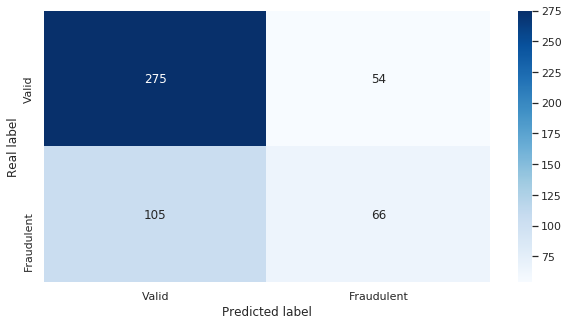

In [278]:
plot_confusion_matrix(conf_matrix, class_labels=['Valid','Fraudulent'])

ROC-AUC score and curve

In [279]:
from sklearn.metrics import roc_curve, roc_auc_score

data.fraudulent.value_counts()

f    329
t    171
Name: fraudulent, dtype: int64

In [0]:
# Convert target variable to numeric
data['fraudulent'] = [1 if i=='t' else 0 for i in data['fraudulent']]

In [281]:
data.fraudulent.value_counts()
#roc_auc_score(data['fraudulent'],data['pred_rew_proba'])
#fpr, tpr, _ = roc_curve(data['fraudulent'], data['pred_rew_proba'],drop_intermediate = False)

0    329
1    171
Name: fraudulent, dtype: int64

In [0]:
def get_auc(y, y_pred_probabilities, class_labels, column =1, plot = True):
    """Plots ROC AUC
    """
    fpr, tpr, _ = roc_curve(y, y_pred_probabilities,drop_intermediate = False)
    #roc_auc = roc_auc_score(y_true=y, y_score=y_pred_probabilities[:,1])
    roc_auc = roc_auc_score(y_true=y, y_score=y_pred_probabilities)
    print ("AUC: ", roc_auc)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

AUC:  0.6882632112195383


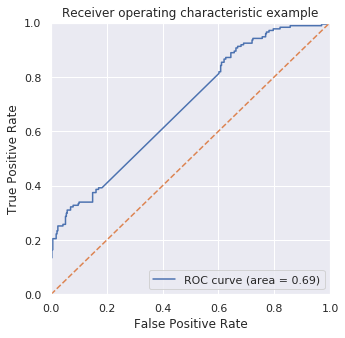

In [283]:
get_auc(y=data['fraudulent'], y_pred_probabilities=data['pred_rew_proba'],
        class_labels=['Valid','Fraudulent'],
        column =1, plot = True)

T-SNE of word embeddings

In [284]:
## Get word embedding vectors from the model
temp_embed = model.embedding
temp_weights = temp_embed.weight
print(temp_weights.shape)

torch.Size([861, 100])


In [0]:
# Load required librarie
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# Initialize T-SNE model
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)

# Convert tensor to numpy array
temp_weights = temp_weights.data.cpu().numpy()

# Fit the model
word_embed_vec2d = tsne_model.fit_transform(temp_weights)

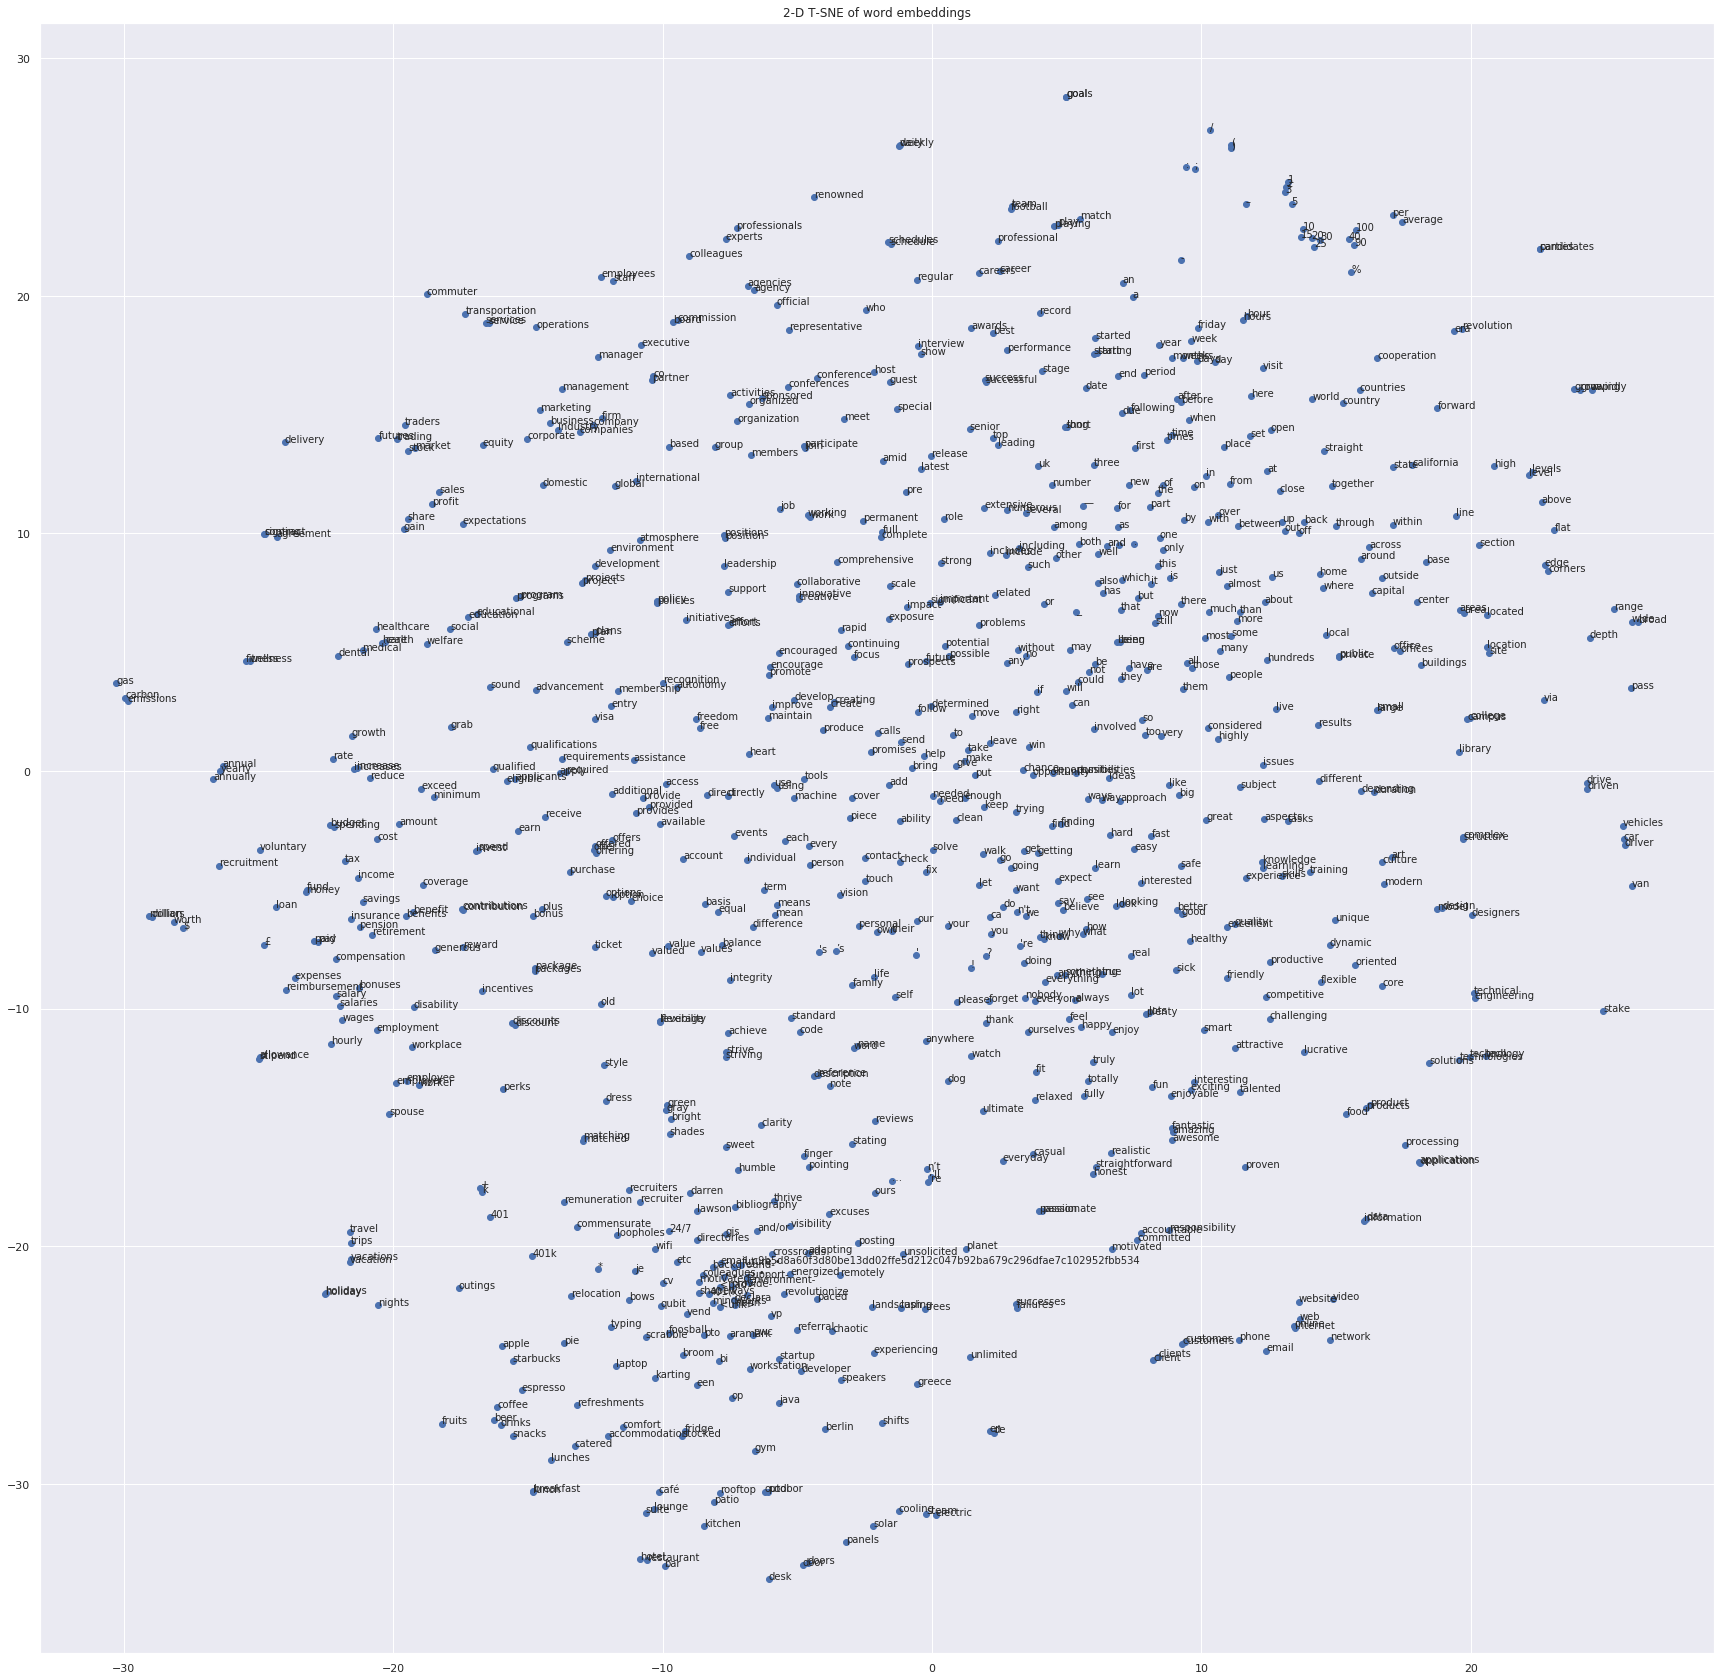

In [287]:
# Visualize
plt.rcParams["figure.figsize"] = (30,30)
plt.scatter(word_embed_vec2d[:,0],word_embed_vec2d[:,1])
plt.title("2-D T-SNE of word embeddings")
for i in range(len(word_embed_vec2d)):
    plt.annotate(TEXT.vocab.itos[i], (word_embed_vec2d[i,0], word_embed_vec2d[i,1]))
plt.show()